In [1]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10, cifar100

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation

import numpy as np
import random

import matplotlib.pyplot as plt

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (10000, 28, 28, 1) (10000, 10) (60000, 28, 28, 1) (60000, 10)


In [4]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu', input_shape=(img_rows, img_cols, channels)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

model = create_model()

In [5]:
model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(x_test, y_test))

print("Base accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0329 - accuracy: 0.7565 - val_loss: 0.0065 - val_accuracy: 0.9570
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0097 - accuracy: 0.9373 - val_loss: 0.0049 - val_accuracy: 0.9681
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0076 - accuracy: 0.9513 - val_loss: 0.0046 - val_accuracy: 0.9696
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0064 - accuracy: 0.9589 - val_loss: 0.0040 - val_accuracy: 0.9744
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0059 - accuracy: 0.9629 - val_loss: 0.0040 - val_accuracy: 0.9739
Epoch 6/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0050 - accuracy: 0.9680 - val_loss: 0.0035 - val_accuracy: 0.9770
Epoch 7/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0050 - accuracy: 0.9685 - val_loss: 0.0035 - val_accuracy:

In [6]:
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

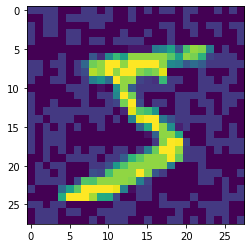

In [7]:
image = x_train[0]
image_label = y_train[0]
perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
adversarial = image + perturbations * 0.1

if channels == 1:
    plt.imshow(adversarial.reshape((img_rows, img_cols)))
else:
    plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))
plt.show()

In [8]:
print(labels[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()])
print(labels[model.predict(adversarial).argmax()])

five
three


In [9]:
def generate_adversarials(batch_size):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)

            label = y_train[N]
            image = x_train[N]
            
            perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            
            
            epsilon = 0.1
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(y_train[N])
        
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        
        yield x, y

In [10]:
x_adversarial_test, y_adversarial_test = next(generate_adversarials(10000))

In [11]:
print("Base accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

Base accuracy on adversarial images: [0.13547231256961823, 0.2337000072002411]
